Load Data and Synchronize Timestamps


In [19]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt

Load both the file


In [20]:
print("Loading and synchronizing data...")
slam_df = pd.read_csv('SLAM_poses_v2.csv')
gnss_df = pd.read_csv('GNSS_data_v2.csv')

Loading and synchronizing data...


Cleaning Data


In [21]:
gnss_df_clean = gnss_df.dropna(subset=['latitude', 'longitude', 'altitude']).copy()

Find the nearest timestemp and arrange the data


In [22]:
gnss_timestamps = gnss_df_clean['#timestamp'].values
tree = KDTree(gnss_timestamps.reshape(-1, 1))
distances, indices = tree.query(slam_df['#timestamp'].values.reshape(-1, 1))

In [23]:
matched_gnss_df = gnss_df_clean.iloc[indices].reset_index(drop=True)

In [24]:
slam_df.rename(columns={'#timestamp': 'slam_timestamp'}, inplace=True)
matched_gnss_df.rename(columns={'#timestamp': 'gnss_timestamp'}, inplace=True)

In [25]:
merged_df = pd.concat([slam_df, matched_gnss_df], axis=1)

GNSS Data conversion to ENU


In [26]:
lat0 = merged_df['latitude'].iloc[0]
lon0 = merged_df['longitude'].iloc[0]
alt0 = merged_df['altitude'].iloc[0]

In [27]:
import pymap3d as pm

gnss_x, gnss_y, gnss_z = pm.geodetic2enu(
    merged_df['latitude'], merged_df['longitude'], merged_df['altitude'],
    lat0, lon0, alt0
)

In [28]:
merged_df['gnss_x'] = gnss_x
merged_df['gnss_y'] = gnss_y
merged_df['gnss_z'] = gnss_z
print("DataFrame with Manually Converted ENU Coordinates:")
print(merged_df[['slam_timestamp', 'x', 'y', 'z', 'gnss_x', 'gnss_y', 'gnss_z']].head())

DataFrame with Manually Converted ENU Coordinates:
   slam_timestamp          x          y         z     gnss_x     gnss_y  \
0    1.748446e+09   0.036351   0.102223  0.058467   0.000000   0.000000   
1    1.748447e+09  28.842144 -14.318452  0.220654 -45.644066  -0.210993   
2    1.748447e+09  51.660431 -15.166374  0.171996 -24.264592  -6.864628   
3    1.748447e+09 -14.969348   1.801019  0.089285 -83.224507  29.484874   
4    1.748447e+09  10.723640 -13.914563  0.297292 -63.392031   8.959986   

     gnss_z  
0  0.000000  
1  0.134663  
2 -1.023549  
3 -4.293213  
4 -1.165849  


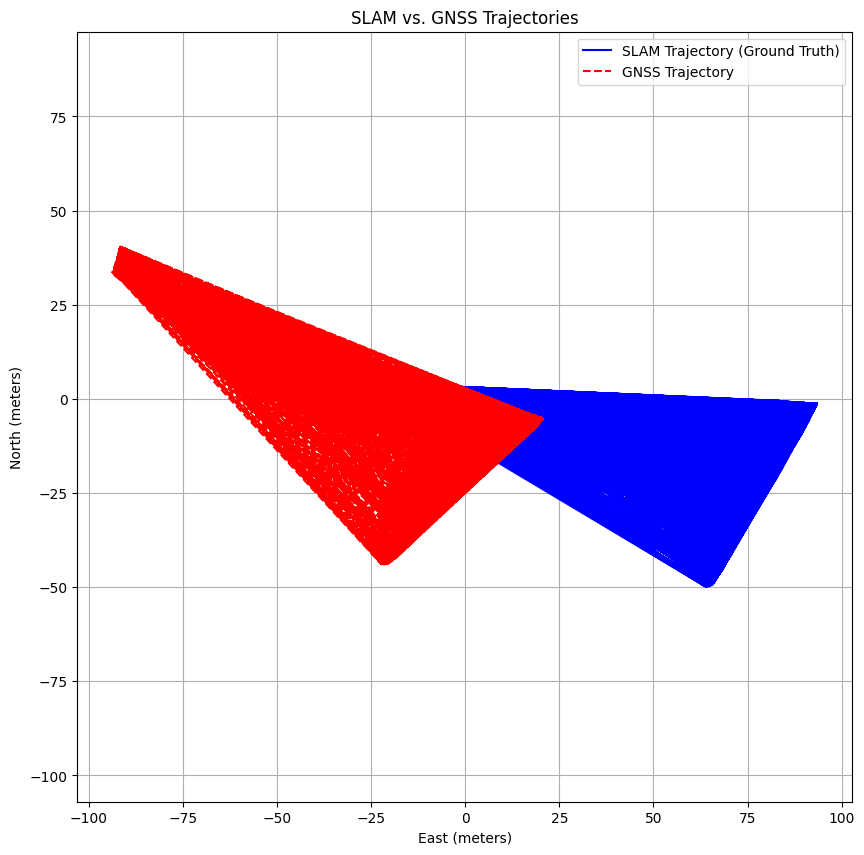

In [29]:
plt.figure(figsize=(10, 10))
# Plot the SLAM trajectory (ground truth) in blue
plt.plot(merged_df['x'], merged_df['y'], label='SLAM Trajectory (Ground Truth)', color='blue')
# Plot the GNSS trajectory in red
plt.plot(merged_df['gnss_x'], merged_df['gnss_y'], label='GNSS Trajectory', color='red', linestyle='--')

plt.xlabel('East (meters)')
plt.ylabel('North (meters)')
plt.title('SLAM vs. GNSS Trajectories')
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensures the scale is the same on both axes
plt.show()

Calculating the Error


In [30]:
merged_df['position_error'] = np.sqrt(
    (merged_df['x'] - merged_df['gnss_x'])**2 +
    (merged_df['y'] - merged_df['gnss_y'])**2
)

print("Position Error Statistics (in meters):")
print(merged_df['position_error'].describe())

Position Error Statistics (in meters):
count    2093.000000
mean       64.919332
std        23.321353
min         0.000445
25%        63.299666
50%        74.940287
75%        77.053716
max        86.444218
Name: position_error, dtype: float64


Generating scatter plot...

Plot 'correlation_scatter.png' has been saved to your folder.


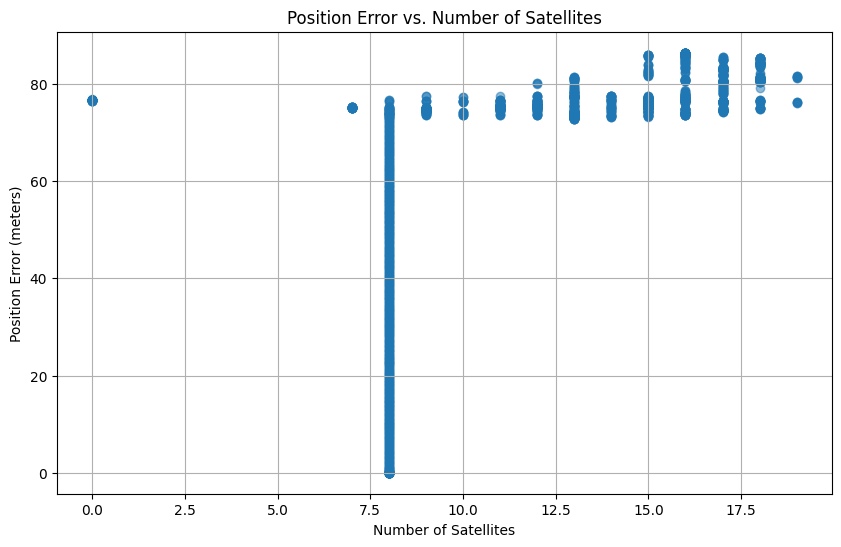

In [34]:
print("Generating scatter plot...")
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['satellite_num'], merged_df['position_error'], alpha=0.5)
plt.xlabel('Number of Satellites')
plt.ylabel('Position Error (meters)')
plt.title('Position Error vs. Number of Satellites')
plt.grid(True)
plt.savefig('correlation_scatter.png')
    
print("\nPlot 'correlation_scatter.png' has been saved to your folder.")
    
    # Display the plot
plt.show()